In [251]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#import
import javabridge
import bioformats
import pickle
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy
import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
from numpy import asarray

import skimage
from skimage import exposure
from skimage import external 
from skimage import filters
from skimage import exposure
from skimage.transform import resize
from skimage.feature import register_translation

javabridge.start_vm(class_path=bioformats.JARS)

import tifffile
from skimage.transform import resize
from tifffile import imsave
from PIL import Image

import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from torchvision.models import vgg16_bn
from  functions_super_res_create_training_im import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Paths were the different images can be found:

In [252]:
path = '../../../../../SCRATCH2/marvande/data/train/'

#path of big LR:
path_lr_whole = path + 'LR/0013_Scan1.qptiff'

#path where we will save the resized HR phenotype patches:
path_lr = path + 'HR/HR_patches_resized/tiff_files/'

#path to HR phenotype patches:
path_hr = path + 'HR/HR_patches_original/'

#path where we will save the HR patches in 6 channel form
#(originally 6 phenotype images with 3 channels)
path_save_hr = path + 'HR/HR_patches_train/tiff_files/'

### Exploring the data: 
Take a look at a few images and their shapes: 

In [253]:
#Load an HR patch and a LR scan to have a look at it:
whole_lr_scan = bioformats.load_image(path_lr_whole)

hr_patch = bioformats.load_image(path_hr + 'im3/0013_[39667,16250].im3')

hr_patho_patch = bioformats.load_image(
    path_hr + '0124_[43058,10798]_CK_OPAL690_path_view.tif')

print('Whole LR scan shape:' + str(whole_lr_scan.shape))
print('HR patch shape:' + str(hr_patch.shape))
print('HR patho patch shape:' + str(hr_patho_patch.shape))

Whole LR scan shape:(15600, 13920, 5)
HR patch shape:(1004, 1344, 35)
HR patho patch shape:(1004, 1344, 3)


Resize one phenotype patch to have a look at them:

One channel of HR patho patch:
HR patch shape:(1004, 1344, 3)


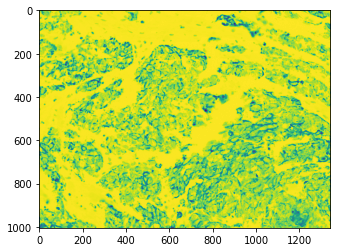


Resized HR patch shape:(500, 669, 3)


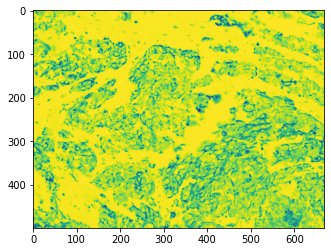

In [254]:
#need to import again because somehow bugs:
from skimage.transform import resize

#Resize HR patch to LR patch size of (500, 669):
hr_patch = bioformats.load_image(
    path_hr + '0124_[43058,10798]_CK_OPAL690_path_view.tif')

#Take one channel:
print('One channel of HR patho patch:')
print('HR patch shape:' + str(hr_patch.shape))
plt.imshow(hr_patch[:, :, 1])
plt.show()

print('')
hr_patch_resized = resize(hr_patch, (500, 669), anti_aliasing=True)
print('Resized HR patch shape:' + str(hr_patch_resized.shape))
plt.imshow(hr_patch_resized[:, :, 1])

No visible difference. Looks good. 

### Creating our training data: 
We will resize the HR phenotype patches (6 phenotypes with 3 channels) to images of 6 channels (one per phenotype). We will create two training dataset for our model: 
- resized patches (LR) of size (500, 669, 6)
- original patches (HR) of size (500, 669, 6)

We wrote some functions for that (see `functions_super_res_create_training_im.py`) and will test them first to see if they behave properly. 

#### Test `correct_file()`: 
a function that tests whether a file has the location, patient and phenotype we want. 

In [255]:
#uncomment if you want to see the signature:
#?correct_file

In [256]:
phenotypes = ['CD4', 'CK', 'DAPI', 'CD3', 'FoxP3', 'CD8']
patient = '0013'
location = '[39667,16250]'

# Some checks for our function:
assert (correct_file(
    location, patient, phenotypes,
    '0013_[39667,16250]_Autofluorescence_path_view.tif') == False)
assert (correct_file(location, patient, phenotypes,
                     '0013_[39667,16250]_CD4_Rhod_path_view.tif') == True)
assert (correct_file(location, patient, phenotypes,
                     '0015_[39667,16250]_CD4_Rhod_path_view.tif') == False)
assert (correct_file(location, patient, phenotypes,
                     '0013_[39660,16253]_CD4_Rhod_path_view.tif') == False)

#### Test `multichannel_phenotype()`: 
a function that creates a 6 channel image for a location of an HR patch
    each channel is a phenotype output of inform. We plot an image with all its six channels to have a look. 

In [257]:
#uncomment if you want to see the signature:
#?multichannel_phenotype

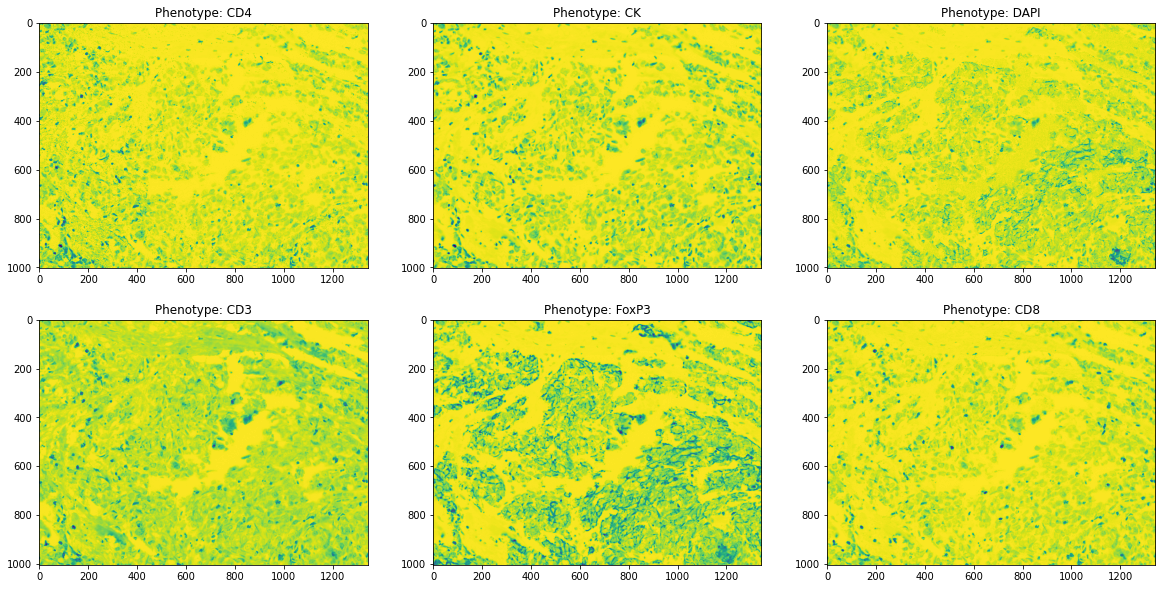

In [261]:
#Test our functions:
patient = '0124'
location = '[43058,10798]'
phenotypes = ['CD4', 'CK', 'DAPI', 'CD3', 'FoxP3', 'CD8']
new_size = (500, 669, 3)

#create the image
arr = multichannel_phenotype(patient=patient,
                             location=location,
                             phenotypes=phenotypes,
                             path_hr=path_hr,
                             path_lr=path_lr,
                             new_size=(1004,1344, 3))
#plot the channels:
show_6_chann_phen(arr, phenotypes)

Attention: somehow bioformats is unable to read all 6 channels, use tifffile.imread (see above)

#### Create the LR and HR training data:

In [237]:
"""
# Create LR train data: 
with os.scandir(path_hr) as entries:
        files = [entry.name for entry in entries if entry.is_file()]

patients = np.unique([file[0:4] for file in files])
print('Patients:', patients)

phenotypes = ['CD4', 'CK', 'DAPI', 'CD3', 'FoxP3', 'CD8']
new_size = (500, 669, 3)

create_train_data(patients, phenotypes, path_hr = path_hr, path_lr = path_lr, resize_size = new_size)
"""

"\n# Create LR train data: \nwith os.scandir(path_hr) as entries:\n        files = [entry.name for entry in entries if entry.is_file()]\n\npatients = np.unique([file[0:4] for file in files])\nprint('Patients:', patients)\n\nphenotypes = ['CD4', 'CK', 'DAPI', 'CD3', 'FoxP3', 'CD8']\nnew_size = (500, 669, 3)\n\ncreate_train_data(patients, phenotypes, path_hr = path_hr, path_lr = path_lr, resize_size = new_size)\n"

In [240]:
# Create HR train data:

patients = np.unique([file[0:4] for file in files])
print('Patients:', patients)

phenotypes = ['CD4', 'CK', 'DAPI', 'CD3', 'FoxP3', 'CD8']

create_train_data(patients=patients,
                  phenotypes=phenotypes,
                  path_hr=path_hr,
                  path_lr=path_save_hr,
                  to_resize=False)

Patients: ['0013' '0015' '0111' '0114' '0116' '0124' '0126']
Saving to:  ../../../../../SCRATCH2/marvande/data/train/HR/HR_patches_train/tiff_files/
Patient: 0013
Locations for patient 0013 :['[39667,16250]' '[39800,12884]' '[39971,13969]' '[40435,17299]' '[40800,15311]' '[41155,18202]' '[41581,13042]'
 '[41886,17360]' '[41972,16104]' '[42435,14969]' '[42508,18299]' '[42727,13165]' '[43142,14323]' '[43374,16750]'
 '[43448,19190]' '[43887,15494]' '[43899,17666]' '[44240,12420]' '[44460,13616]' '[44533,18861]' '[44911,14762]'
 '[45619,18141]' '[45654,12188]' '[45899,13286]' '[46009,16800]' '[46374,14384]' '[46887,12250]' '[47082,10957]'
 '[47107,17422]' '[47192,15519]' '[47813,13335]' '[47960,12091]' '[47996,14555]' '[48144,16531]' '[48156,10238]'
 '[48801,9286]' '[49240,12701]' '[49265,13676]' '[49314,15677]' '[49400,14640]' '[49582,10554]' '[49911,11615]'
 '[49923,9676]']
Finished patient:0013
Patient: 0015
Locations for patient 0015 :['[36259,19783]' '[36877,18933]' '[36929,17465]' '[

In [241]:
# Create test train data:

patients = ['0131']
print('Patients:', patients)

phenotypes = ['CD4', 'CK', 'DAPI', 'CD3', 'FoxP3', 'CD8']

path_test = path + 'HR/HR_patches_test/'
path_test_save = path + 'HR/HR_patches_test/cut_images/'

create_train_data(patients=patients,
                  phenotypes=phenotypes,
                  path_hr=path_test,
                  path_lr=path_test_save,
                  to_resize=False)

Patients: ['0131']
Saving to:  ../../../../../SCRATCH2/marvande/data/train/HR/HR_patches_test/cut_images/
Patient: 0131
Locations for patient 0131 :['[38744,8571]' '[38831,10341]' '[38905,17191]' '[39168,15113]' '[39373,13898]' '[39813,12991]' '[40090,17366]'
 '[40237,15610]' '[40280,14805]' '[40734,12991]' '[40896,13825]' '[40968,17689]' '[41114,18347]' '[41730,12537]'
 '[41817,9961]' '[42051,17060]' '[42198,11863]' '[42212,15523]' '[42242,13869]' '[42579,8381]' '[42696,14454]'
 '[42912,16664]' '[43076,8951]' '[43515,10518]' '[44467,14410]' '[45213,9683]' '[45930,8132]' '[46589,13751]'
 '[46740,17995]' '[46800,15428]' '[46833,16191]' '[47276,11863]' '[47748,18478]' '[47765,19400]' '[47891,9800]'
 '[48485,17537]' '[48866,16300]' '[49577,17995]' '[50072,7868]' '[50594,17393]' '[50731,8702]' '[50789,13870]']
Finished patient:0131
Done with all patients


## Tests:

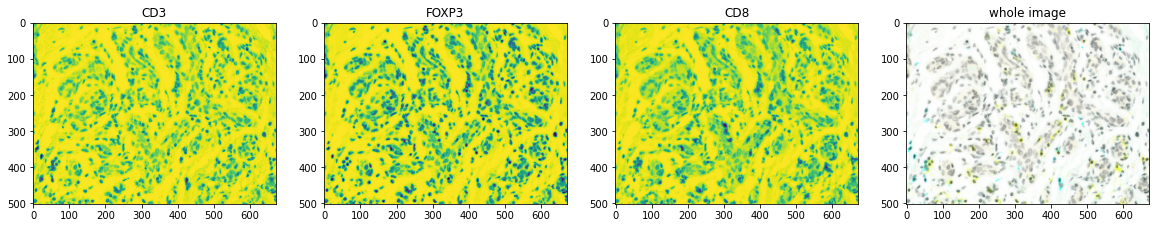

In [274]:
patient = '0015'
location = '[45687,15816]' 
files =[]
fil = []
with os.scandir(path_save_hr) as entries:
    files = [entry.name for entry in entries if entry.is_file()]
fil= [f for f in files if patient in f and location in f]

p = path_save_hr + '0015_[45687,15816]_part_4_2_.tif'

img = np.asarray(Image.open(p))
figure, ax = plt.subplots(1, 4, figsize=(20, 20))
ax[0].imshow(img[:,:,0])
ax[0].set_title('CD3')
ax[1].imshow(img[:,:,1])
ax[1].set_title('FOXP3')
ax[2].imshow(img[:,:,2])
ax[2].set_title('CD8')
ax[3].imshow(Image.open(p))
ax[3].set_title('whole image');

